In [1]:
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt

### my library

import plots
import utils
import images
import distances
import transforms
import alignments

In [2]:
# ### MNIST DATA
# mnist_image_file = 'Data/t10k-images-idx3-ubyte.gz'
# mnist_label_file = 'Data/t10k-labels-idx1-ubyte.gz'

# mnist_images = utils.load_mnist_images(mnist_image_file)
# mnist_labels = utils.load_mnist_labels(mnist_label_file)

# digit = 2
# loc = np.argwhere(digit == mnist_labels).flatten()
# digit_images = mnist_images[loc]

# L = 65
# img1 = mnist_images[1]
# img2 = mnist_images[1]
# x = np.array([img1, img2])
# x = utils.zero_pad_image_stack_to_size(x, L)



# ### CAMERA MAN DATA
# from skimage import data
# L = 650
# x = np.array([data.camera(), data.camera()])
# x = utils.zero_pad_image_stack_to_size(x, L)



# ### DISK
# L = 128
# img1 = np.ones((L,L))
# img1 = img1 * utils.sphere_mask(utils.radial_distance_grid([L,L]), radius=20)
# x = np.array([img1, img1])


# ### SQUARE
# L = 128
# img1 = np.zeros((L,L))
# img1[54:74, 54:74] = 1
# x = np.array([img1, img1])


### GAUSSIAN

def gaussian_2d(N, A=1, sig_x=1, sig_y=1):
    """returns simple 2D Gaussian over range -3 to 3 of size NxN"""
    xs = np.linspace(-3, 3, N)
    ys = np.linspace(-3, 3, N)
    x, y = np.meshgrid(xs, ys)
    g = A*np.exp(-((x**2 / 2*sig_x**2) + (y**2 / 2*sig_y**2)))
    return g

amp = 1000  # a.u.
L = 128
g = gaussian_2d(L, A=amp, sig_x=5, sig_y=5)  # using large amplitude because of scaling

img1 = np.zeros((L, L))
img1[L//2, L//2] = 1
img1 = transforms.ift2(transforms.ft2(img1) * g).real
x = np.array([img1, img1])

In [3]:
n_shifts = 15
shifts = np.arange(n_shifts+1)*3
imgs = np.zeros((n_shifts+1, L, L))

for idx, s in enumerate(shifts):
    imgs[idx] = utils.translate(x[0], 0, s)
    
imgs = images.Image(imgs, normalize=True, mask=True).preprocess_images()

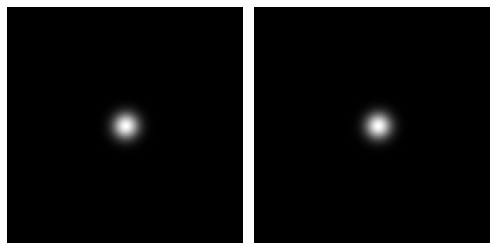

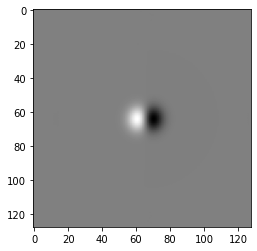

In [4]:
s_idx = 1
plots.two_imshow(imgs[0], imgs[s_idx], cmap='gray')
plt.imshow(imgs[0] - imgs[s_idx], cmap='gray')
plt.show()

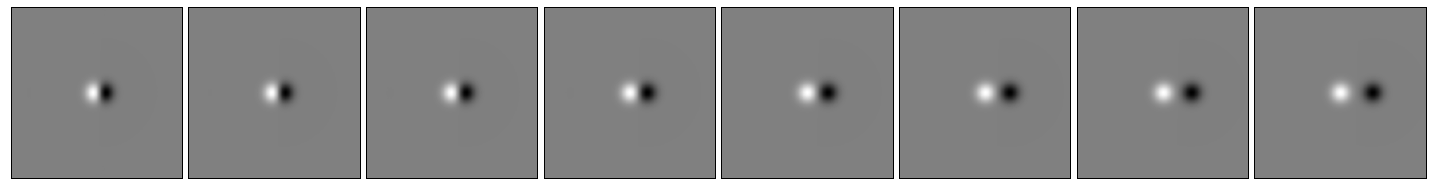

In [5]:
plots.line_tile_plot(imgs[0] - imgs[1::n_shifts//8], 8, size=20, spine_colors=['k' for _ in range(10)], cmap='gray')

In [6]:
N, ny, nx = imgs.shape
n_points = ny
angles = np.linspace(0, 360, ny, endpoint=False)
n_theta = len(angles)


### sliced Cramer distance (no ramp filter)
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform()
dists_sc_nrf = np.array([distances.sliced_distance(V[0], V[idx]) for idx in range(N)])


### sliced Wasserstein distance (no ramp filter)
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
dists_sw_nrf = np.array([distances.sliced_distance(V[0], V[idx]) for idx in range(N)])
    

### sliced Wasserstein distance (signed)
Vp, Vn = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
dists_sw_sgn = np.array([distances.signed_sliced_distance(Vp[0], Vp[idx], Vn[0], Vn[idx]) for idx in range(N)])


## Euclidean
dists_l2 = np.array([distances.l2_distance(imgs[0], imgs[idx]) for idx in range(N)])

In [7]:
upper_bound_sw = np.sqrt(2) / 2 * (shifts / L)

upper_bound_sc = np.sqrt(2) * (shifts / L) 

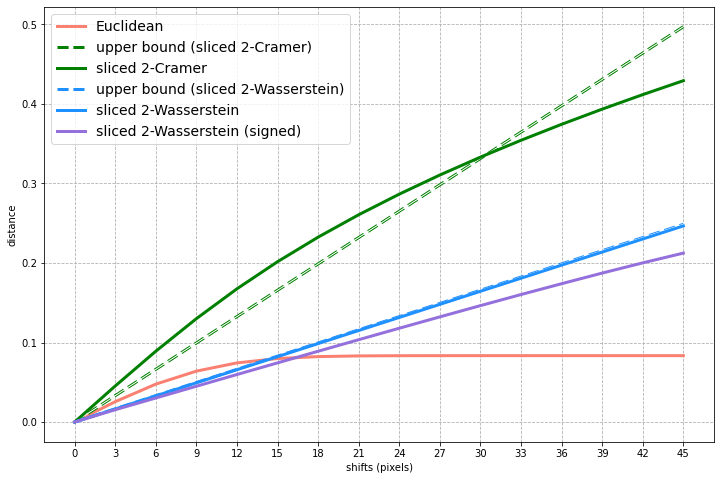

In [8]:
plt.figure(figsize=(12,8))

colors = {'sw_nrf': 'dodgerblue',
          'sw_sgn': 'mediumpurple',
          'sw_max': 'pink',
          'sc_nrf': 'green',
          'bf': 'salmon', 
          'w2': 'blue'}


plt.plot(shifts[:], dists_l2[:], color=colors['bf'], linestyle='-', linewidth=3, label='Euclidean')

plt.plot(shifts[:], upper_bound_sc[:], color=colors['sc_nrf'], linestyle='--', linewidth=3, label='upper bound (sliced 2-Cramer)')
plt.plot(shifts[:], upper_bound_sc[:], color='white', linestyle='-', linewidth=1)

plt.plot(shifts[:], dists_sc_nrf[:], color=colors['sc_nrf'], linestyle='-', linewidth=3, label='sliced 2-Cramer')

plt.plot(shifts[:], upper_bound_sw[:], color=colors['sw_nrf'], linestyle='--', linewidth=3, label='upper bound (sliced 2-Wasserstein)')
plt.plot(shifts[:], upper_bound_sw[:], color='white', linestyle='-', linewidth=1)

plt.plot(shifts[:], dists_sw_nrf[:], color=colors['sw_nrf'], linestyle='-', linewidth=3, label='sliced 2-Wasserstein')

plt.plot(shifts[:], dists_sw_sgn[:], color=colors['sw_sgn'], linestyle='-', linewidth=3, label='sliced 2-Wasserstein (signed)')



plt.xticks(shifts)
plt.grid(which='major', linestyle='--')
plt.ylabel('distance')
plt.xlabel('shifts (pixels)')
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=14)
plt.legend()
plt.show()

In [ ]:
### questions ###

### bounds are ||v|| but need to be rescaled?
### how to make W2 and EMD be scaled?
### sc bounds?
### shouldn't it be sum and not mean for d_w2?

### if continuous SW is average over angles, how to denote this in matrix form
### ### is this what is being computed in the fast version? does it matter?
### ### shouldn't it be mean of columns? not all entries

In [ ]:
t = time.time()

N, ny, nx = imgs.shape
n_points = ny
angles = np.linspace(0, 360, ny, endpoint=False)
n_theta = len(angles)


### sliced Cramer distance (no ramp filter)
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform()
Vs = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform()

dists_sc_nrf = np.zeros(n_shifts+1)

for idx in range(n_shifts+1):
        
    d_c2 = np.mean((U[0] - Vs[idx])**2, axis=0)
    d_sc2 = np.sqrt(np.mean(d_c2))
    
    dists_sc_nrf[idx] = d_sc2


### sliced Wasserstein distance (no ramp filter)
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
Vs = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()

dists_sw_nrf = np.zeros(n_shifts+1)

for idx in range(n_shifts+1):
        
    d_w2 = np.mean((U[0] - Vs[idx])**2, axis=0)
    d_sw2 = np.sqrt(np.mean(d_w2))
    
    dists_sw_nrf[idx] = d_sw2


### sliced Wasserstein distance (averaged)
U_p, U_n = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
Vs_p, Vs_n = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()

dists_sw_avg = np.zeros(n_shifts+1)

for idx in range(n_shifts+1):

    d_w2_p = np.mean((U_p[0] - Vs_p[idx])**2, axis=0)
    d_sw2_p = np.sqrt(np.mean(d_w2_p))
    
    d_w2_n = np.mean((U_n[0] - Vs_n[idx])**2, axis=0)
    d_sw2_n = np.sqrt(np.mean(d_w2_n))
    
    dists_sw_avg[idx] = (d_sw2_p + d_sw2_n) / 2

    # dists_sw_avg[idx] = d_sw2_p


### max sliced Wasserstein distance
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
Vs = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()

dists_sw_max = np.zeros(n_shifts+1)

for idx in range(n_shifts+1):
        
    d = np.mean((U[0] - Vs[idx])**2, axis=0)    

    dists_sw_max[idx] = np.sqrt(np.amax(d))


## Brute force rotations
dists_bfr = np.array([np.linalg.norm(refs[0] - imgs[idx]) for idx in range(N)])

print(time.time() - t)

In [ ]:
upper_bound_sw = np.sqrt(2) / 2 * (shifts / L)

upper_bound_sc = 2 * upper_bound_sw

In [ ]:
plt.plot(np.diff(dists_sc_nrf))
plt.plot(np.diff(dists_sw_nrf))

In [ ]:
plt.figure(figsize=(16,12))

# plt.plot(shifts[1:], dists_sw_nrf[1:], label='sliced 2-Wasserstein')
# plt.plot(shifts[1:], dists_sw_avg[1:], label='sliced 2-Wasserstein (signed)')
# plt.plot(shifts[1:], dists_sw_max[1:], label='max sliced 2-Wasserstein')
# plt.plot(shifts[1:], dists_sc_nrf[1:], label='sliced 2-Cramer')
# plt.plot(shifts[1:], dists_bfr[1:], label='Euclidean')

# plt.plot(shifts[1:], upper_bound_sw[1:], color='black', linestyle='--', label='upper bound s2w')
# plt.plot(shifts[1:], upper_bound_sc[1:], color='grey', linestyle='--', label='upper bound s2c')


plt.plot(shifts[:], dists_sw_nrf[:], label='sliced 2-Wasserstein')
# plt.plot(shifts[:], dists_sw_avg[:], label='sliced 2-Wasserstein (signed)')
# plt.plot(shifts[:], dists_sw_max[:], label='max sliced 2-Wasserstein')
plt.plot(shifts[:], dists_sc_nrf[:], label='sliced 2-Cramer')
plt.plot(shifts[:], dists_bfr[:], label='Euclidean')

plt.plot(shifts[:], upper_bound_sw[:], color='black', linestyle='--', label='upper bound s2w')
plt.plot(shifts[:], upper_bound_sc[:], color='grey', linestyle='--', label='upper bound s2c')


plt.legend()
plt.xticks(shifts[:])
plt.grid(which='major', linestyle='--')
plt.show()

In [ ]:
# ### sliced Cramer distance (no ramp filter)
# U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform()
# Vs = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform()

# plt.imshow(U[0])
# plt.colorbar()
# plt.show()

# plt.plot(U[0, :, 0])
# plt.show()

In [ ]:
# ###### Shows that there is some approximation error in signed, could be causing bad results

# ### sliced Wasserstein distance (averaged)
# U_p, U_n = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
# Vs_p, Vs_n = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()


# plt.imshow(U_n[0])
# plt.colorbar()
# plt.show()

# plt.plot(U_n[0, :, 0])
# plt.show()

# plt.imshow(imgs[0])
# plt.show()
# plt.imshow(imgs[1])
# plt.show()
# plt.imshow(imgs[0] - imgs[1])

# X = np.array([imgs[0], imgs[1]])

# X_t = transforms.Transform(X, apply_ramp=True, angles=angles, n_points=n_points).radon_transform()

# plt.imshow(X_t[0])
# plt.colorbar()
# plt.show()
# plt.imshow(X_t[1])
# plt.colorbar()
# plt.show()

# plt.plot(X_t[0, :, 9])
# plt.plot(X_t[1, :, 9])

In [ ]:
t = time.time()

N, ny, nx = imgs.shape
n_points = ny
angles = np.linspace(0, 360, ny, endpoint=False)
n_theta = len(angles)


### sliced Cramer distance (no ramp filter)
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform()
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform()

dists_sc_nrf = np.array([distances.sliced_distance(U[0], V[idx]) for idx in range(N)])


### sliced Wasserstein distance (no ramp filter)
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
    
dists_sw_nrf = np.array([distances.sliced_distance(U[0], V[idx]) for idx in range(N)])
    

### sliced Wasserstein distance (averaged)
Up, Un = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
Vp, Vn = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
    
dists_sw_avg = np.array([distances.signed_sliced_distance(Up[0], Vp[idx], Un[0], Vn[idx]) for idx in range(N)])

## Brute force rotations
dists_bfr = np.array([distances.l2_distance(refs[0], imgs[idx]) for idx in range(N)])

print(time.time() - t)

In [ ]:
upper_bound_sw = np.sqrt(2) / 2 * (shifts / L)

upper_bound_sc = np.sqrt(2) * (shifts / L) 

In [ ]:
plt.figure(figsize=(8,6))


plt.plot(shifts[:], dists_bfr[:], color=colors['bf'], linestyle='-', linewidth=3, label='Euclidean')

plt.plot(shifts[:], upper_bound_sc[:], color=colors['sc_nrf'], linestyle='--', linewidth=3, label='upper bound (sliced 2-Cramer)')
plt.plot(shifts[:], upper_bound_sc[:], color='white', linestyle='-', linewidth=1)

plt.plot(shifts[:], dists_sc_nrf[:], color=colors['sc_nrf'], linestyle='-', linewidth=3, label='sliced 2-Cramer')

plt.plot(shifts[:], upper_bound_sw[:], color=colors['sw_nrf'], linestyle='--', linewidth=3, label='upper bound (sliced 2-Wasserstein)')
plt.plot(shifts[:], upper_bound_sw[:], color='white', linestyle='-', linewidth=1)

plt.plot(shifts[:], dists_sw_nrf[:], color=colors['sw_nrf'], linestyle='-', linewidth=3, label='sliced 2-Wasserstein')


plt.xticks(shifts)
plt.grid(which='major', linestyle='--')
plt.ylabel('distance')
plt.xlabel('shifts (pixels)')
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=14)
plt.legend()
plt.show()

In [ ]:
# L = 65

# img1 = digit_images[0]
# img2 = digit_images[1]

# x = np.array([img1, img2])
# x = utils.zero_pad_image_stack_to_size(x, L)

# refs = np.array([x[0], x[0]])
# imgs = np.array([x[1], x[1]])

# refs = images.Image(refs, normalize=True).preprocess_images()
# imgs = images.Image(imgs, normalize=True).preprocess_images()

In [ ]:
# plots.two_imshow(x[0], x[1])

In [ ]:
# N, ny, nx = imgs.shape

# angles = np.linspace(0, 360, ny, endpoint=False)
# n_points = ny
# n_theta = len(angles)

# ### sliced Wasserstein distance (signed)
# t = time.time()
# Up, Un = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
# Vp, Vn = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
# dists_dict_sw_sgn = distances.reference_signed_rotational_distances(Up[0], Vp, Un[0], Vn)
# angles_est_sw_sgn = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_sw_sgn.items()])
# print('SW sgn runtime: ', time.time() - t)

# ## Brute force rotations
# t = time.time()
# dists_dict_bf = {idx: distances.real_space_rotational_distance(refs, imgs[idx], angles) for idx in range(N)}
# angles_est_bf = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_bf.items()])
# print('    BF runtime: ', time.time() - t)


# ### Wasserstein
# t = time.time()
# M = distances.compute_transport_matrix(imgs[0], metric='sqeuclidean')
# dists_dict_w2 = {0: distances.rotational_wasserstein_distance(refs[0], imgs[0], angles, M)}
# angles_est_w2 = np.array([angles[np.argmin(dists)] for idx, dists in dists_dict_w2.items()])
# print('  W2 runtime: ', time.time() - t)

In [ ]:
# img_sw_sgn = utils.rotate(imgs[0], -angles_est_sw_sgn[0])
# img_l2 = utils.rotate(imgs[0], -angles_est_bf[0])
# img_w2 = utils.rotate(imgs[0], -angles_est_w2[0])

In [ ]:
# # plots.line_tile_plot(np.array([imgs[0], refs[0], img_sw_sgn, img_w2]), length=4, spine_colors=['k' for _ in range(4)])
# plt.imshow(imgs[0])
# plt.axis('off')
# plt.show()
# plt.imshow(refs[0])
# plt.axis('off')
# plt.show()
# plt.imshow(refs[0] - img_sw_sgn)
# plt.axis('off')
# plt.show()
# plt.imshow(refs[0] - img_l2)
# plt.axis('off')
# plt.show()
# plt.imshow(refs[0] - img_w2)
# plt.axis('off')
# plt.show()